In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q "/content/drive/MyDrive/RSICD.zip" -d "/content"

In [4]:
!pip install nltk tqdm pycocoevalcap --quiet
import nltk
nltk.download('punkt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Set your paths to dataset here
image_folder = '/content/RSICD/images'
json_path = '/content/RSICD/sentences/Dataset.json'


In [6]:
import os
import json
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torch import nn
from tqdm import tqdm
from collections import Counter
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# SECTION 2: Dataset and Vocabulary

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        return nltk.tokenize.word_tokenize(text.lower())

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<unk>"])
            for token in tokenized_text
        ]
# SECTION 3: Dataset Loader

class RSICDDataset(Dataset):
    def __init__(self, root_dir, json_path, vocab, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.images = []
        self.captions = []
        for img in data['images']:
            filename = img['filename']
            for sent in img['sentences']:
                self.images.append(filename)
                self.captions.append(sent['raw'])
        self.vocab.build_vocab(self.captions)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        caption = self.captions[idx]

        if self.transform:
            image = self.transform(image)

        numericalized = [self.vocab.stoi["<start>"]]
        numericalized += self.vocab.numericalize(caption)
        numericalized.append(self.vocab.stoi["<end>"])
        return image, torch.tensor(numericalized)

# SECTION 4: Collate Function

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs, captions = zip(*batch)
        imgs = torch.stack(imgs, 0)
        lengths = [len(cap) for cap in captions]
        padded = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return imgs, padded

In [20]:
# SECTION 5: Encoder (ResNet)

# SECTION 5: Encoder (ResNet)

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14, embed_size=512): # Added embed_size
        super().__init__()
        resnet = resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fc = nn.Linear(resnet.fc.in_features, embed_size) # Added linear layer
        self.fine_tune()

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        features = self.fc(features) # Pass features through linear layer
        return features

    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

# SECTION 6: Transformer Decoder

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class DecoderTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        tgt_emb = self.embedding(tgt) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32)).to(tgt.device)
        tgt_emb = self.pos_encoder(tgt_emb)
        output = self.transformer_decoder(tgt_emb.transpose(0, 1), memory.transpose(0, 1),
                                          tgt_mask=tgt_mask,
                                          tgt_key_padding_mask=tgt_key_padding_mask)
        return self.fc(output.transpose(0, 1))

# SECTION 7: Full Captioning Model

class ImageCaptioningTransformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions, tgt_mask=None):
        memory = self.encoder(images)
        return self.decoder(captions, memory, tgt_mask)

In [21]:
# SECTION 8: Training Setup

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

vocab = Vocabulary(freq_threshold=5)
dataset = RSICDDataset(
    root_dir="/content/RSICD/images",
    json_path="/content/RSICD/sentences/Dataset.json",
    vocab=vocab,
    transform=transform
)
pad_idx = vocab.stoi["<pad>"]
loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True,
                    collate_fn=MyCollate(pad_idx=pad_idx))

encoder = EncoderCNN().to(device)
decoder = DecoderTransformer(vocab_size=len(vocab)).to(device)
model = ImageCaptioningTransformer(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def generate_caption(model, image, vocab, max_len=50):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        memory = model.encoder(image)

        caption = [vocab.stoi["<start>"]]
        for _ in range(max_len):
            cap_tensor = torch.tensor(caption).unsqueeze(0).to(device)
            tgt_mask = generate_square_subsequent_mask(cap_tensor.size(1)).to(device)
            output = model.decoder(cap_tensor, memory, tgt_mask)
            next_token = output.argmax(-1)[:, -1].item()
            caption.append(next_token)
            if next_token == vocab.stoi["<end>"]:
                break

    return [vocab.itos[idx] for idx in caption[1:-1]]


# Training loop
# SECTION 9: Training Loop

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for imgs, captions in tqdm(loader):
        imgs, captions = imgs.to(device), captions.to(device)

        tgt_input = captions[:, :-1]
        tgt_output = captions[:, 1:]
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        outputs = model(imgs, tgt_input, tgt_mask)
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), tgt_output.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1707/1707 [11:53<00:00,  2.39it/s]


Epoch 1, Loss: 1.7236


100%|██████████| 1707/1707 [11:50<00:00,  2.40it/s]


Epoch 2, Loss: 1.1667


100%|██████████| 1707/1707 [11:50<00:00,  2.40it/s]


Epoch 3, Loss: 0.9152


100%|██████████| 1707/1707 [11:51<00:00,  2.40it/s]


Epoch 4, Loss: 0.7381


100%|██████████| 1707/1707 [11:50<00:00,  2.40it/s]

Epoch 5, Loss: 0.6104


In [31]:
torch.save(model.state_dict(), "/content/transformer_caption_model.pth")

In [22]:
 nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [38]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from random import sample

In [39]:
def evaluate_model(model, dataloader, vocab):
    references = []
    hypotheses = []

    model.eval()
    for imgs, captions in tqdm(dataloader):
        imgs = imgs.to(device)
        for img, caption in zip(imgs, captions):
            pred = generate_caption(model, img, vocab)
            target = [vocab.itos[idx.item()] for idx in caption
                      if idx.item() not in {vocab.stoi["<pad>"], vocab.stoi["<start>"], vocab.stoi["<end>"]}]
            references.append([" ".join(target)])
            hypotheses.append(" ".join(pred))

    print("BLEU-1:", corpus_bleu([[ref[0].split()] for ref in references],
                                 [hyp.split() for hyp in hypotheses],
                                 weights=(1, 0, 0, 0)))

    print("BLEU-4:", corpus_bleu([[ref[0].split()] for ref in references],
                                 [hyp.split() for hyp in hypotheses],
                                 weights=(0.25, 0.25, 0.25, 0.25)))


In [41]:
def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    vocab = Vocabulary(freq_threshold=5)
    dataset = RSICDDataset(
        root_dir="/content/RSICD/images",
        json_path="/content/RSICD/sentences/Dataset.json",
        vocab=vocab,
        transform=transform
    )

    # ✅ Subsample dataset for fast evaluation
    # Get indices for 500 random samples
    num_samples = 500
    sampled_indices = sample(range(len(dataset)), num_samples)

    # Subset the images and captions using sampled indices
    dataset.images = [dataset.images[i] for i in sampled_indices]
    dataset.captions = [dataset.captions[i] for i in sampled_indices]


    pad_idx = vocab.stoi["<pad>"]
    dataloader = DataLoader(dataset=dataset, batch_size=16, shuffle=False,
                            collate_fn=MyCollate(pad_idx=pad_idx))

    encoder = EncoderCNN().to(device)
    decoder = DecoderTransformer(vocab_size=len(vocab)).to(device)
    model = ImageCaptioningTransformer(encoder, decoder).to(device)

    # ✅ Load trained model weights
    model.load_state_dict(torch.load("/content/transformer_caption_model.pth"))
    model.eval()

    # ✅ Run evaluation
    evaluate_model(model, dataloader, vocab)

main()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 32/32 [00:45<00:00,  1.43s/it]

BLEU-1: 0.735593350684232
BLEU-4: 0.6138505971256192


In [25]:
def greedy_decode(model, image, vocab, max_len=50):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        memory = model.encoder(image)

        caption = [vocab.stoi["<start>"]]
        for _ in range(max_len):
            cap_tensor = torch.tensor(caption).unsqueeze(0).to(device)
            tgt_mask = generate_square_subsequent_mask(cap_tensor.size(1)).to(device)
            output = model.decoder(cap_tensor, memory, tgt_mask)
            next_token = output.argmax(-1)[:, -1].item()
            caption.append(next_token)
            if next_token == vocab.stoi["<end>"]:
                break

    return [vocab.itos[idx] for idx in caption[1:-1]]

Generated Caption: some boats are in a port near several buildings and green trees .


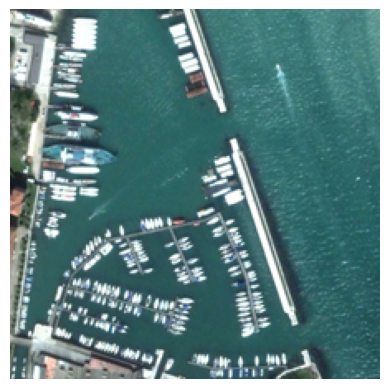

In [26]:
# Get one random image + caption
from random import randint

model.eval()
index = randint(0, len(dataset) - 1)
image, _ = dataset[index]
caption_words = greedy_decode(model, image, vocab)
print("Generated Caption:", " ".join(caption_words))

# Show image
import matplotlib.pyplot as plt
plt.imshow(transforms.ToPILImage()(image))
plt.axis('off')
plt.show()